In [1]:
import os

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import geopandas as gpd

from matplotlib.colors import ListedColormap
from scipy.interpolate import griddata

In [2]:
dciopse=xr.open_dataset('/home/soontiensn/data/gpsc-work7/uncertainty/stlawrence-poc/coastal_data/ciopse_mask_trex_250m.nc')
draster=xr.open_dataset('/home/soontiensn/data/gpsc-work7/uncertainty/stlawrence-poc/coastal_data/mask_trex_250m_from_raster.nc')

In [3]:
dciopse = dciopse.swap_dims({'X': 'lon', 'Y': 'lat'}).transpose('lat', 'lon')

In [4]:
mask1 = dciopse.mask.data # mask 1 is from ciopse
mask2 = np.nan_to_num(draster.Band1.data) # mask 2 is from raster

In [5]:
diff = mask1 - mask2
mask3 = (diff != 0)*1 # mask 3 is where mask1 and mask2 aren't equal

## Load the water.gpkg

In [6]:
water = gpd.read_file('/home/soontiensn/data/gpsc-work7/uncertainty/stlawrence-poc/coastal_data/water.gpkg')

# Defning red with CIOPSE mask

Number of redzone points:  7306490


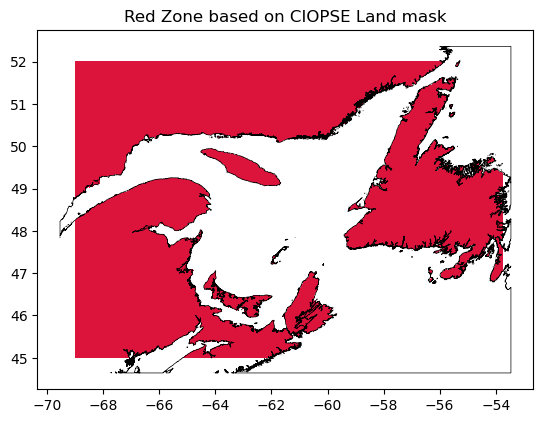

In [7]:
cmap_red = ListedColormap([ "white", "crimson"])
redzone1 = 1-mask1
fig, ax = plt.subplots(1,1)
ax.pcolormesh(dciopse.lon, dciopse.lat, redzone1, cmap=cmap_red)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_title('Red Zone based on CIOPSE Land mask')
print("Number of redzone points: ", np.sum(redzone1))

Number of redzone points:  212561


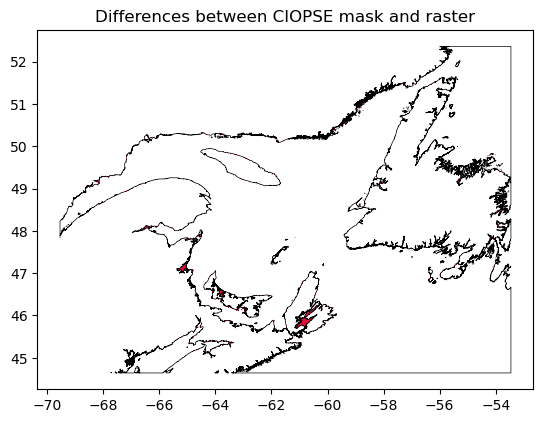

In [8]:
fig, ax = plt.subplots(1,1)
ax.pcolormesh(dciopse.lon, dciopse.lat, mask3, cmap=cmap_red)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_title('Differences between CIOPSE mask and raster')
print("Number of redzone points: ", np.sum(mask3))

Number of redzone points:  7370571


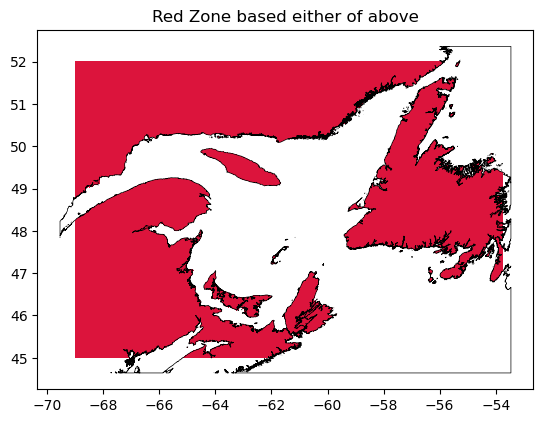

In [9]:
redzone2 = redzone1 | mask3
fig, ax = plt.subplots(1,1)
ax.pcolormesh(dciopse.lon, dciopse.lat, redzone2, cmap=cmap_red)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_title('Red Zone based either of above')
print("Number of redzone points: ", np.sum(redzone2))

Number of additional redzone points:  64081


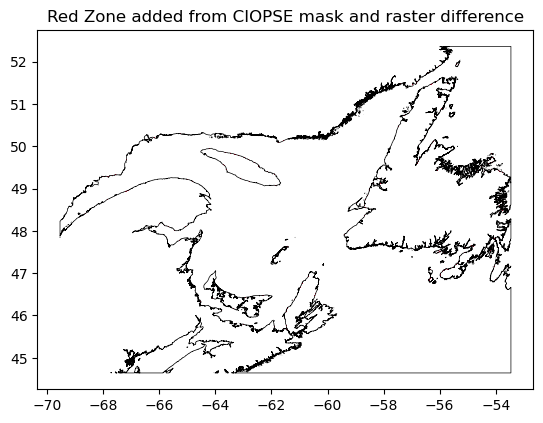

In [10]:
additional_points = ~redzone1 & mask3
fig, ax = plt.subplots(1,1)
ax.pcolormesh(dciopse.lon, dciopse.lat, additional_points, cmap=cmap_red)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_title('Red Zone added from CIOPSE mask and raster difference')
print("Number of additional redzone points: ", np.sum(additional_points))

## Zooming in on POC area

(-57.0, -54.0)

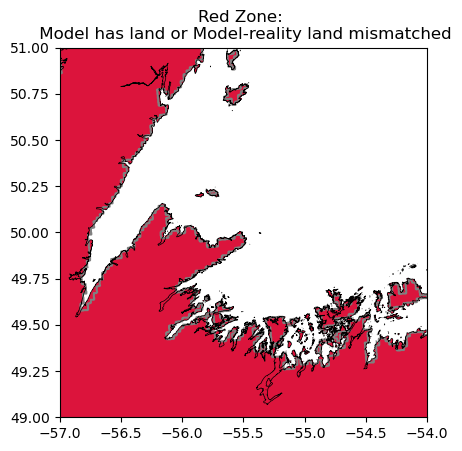

In [13]:
lon_min=-57
lon_max=-54
lat_min=49
lat_max=51

redzone2 = redzone1 | mask3
fig, ax = plt.subplots(1,1)
ax.pcolormesh(dciopse.lon, dciopse.lat, redzone2, cmap=cmap_red)
ax.contour(dciopse.lon, dciopse.lat, dciopse.mask, levels=[0], colors='grey')
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_title('Red Zone: \n Model has land or Model-reality land mismatched')
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])

In [14]:
fig.savefig('redzone_landmask_or_mistmatch_twill.png', bbox_inches='tight', dpi=300)

# Moving onto bathymetry comparisons

In [15]:
dciopse['redzone_landmask'] = xr.DataArray(redzone2, dims=('lat', 'lon'))
dcsub = dciopse.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

In [16]:
gebco = xr.open_dataset('/home/soontiensn/data/gpsc-work7/uncertainty/twillingate/GEBCO_08_Mar_2024_4fe1712a4d42/gebco_2023_n51.0_s49.0_w-57.0_e-54.0.nc')

gebco_interp = gebco.interp(lon=dcsub.lon, lat=dcsub.lat)

gebco = gebco.where(gebco['elevation']<=0)
gebco['depth'] = -gebco['elevation']
gebco['depth'].attrs = {'long_name': 'Depth relative to sea level',
                        'units': 'm'}

gebco_interp= gebco_interp.where(gebco_interp['elevation']<=0)
gebco_interp['depth'] = -gebco_interp['elevation']
gebco_interp['depth'].attrs = {'long_name': 'Depth relative to sea level',
                              'units': 'm'}

In [17]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
gebco.depth.plot(ax=ax)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])
ax.set_title('GEBCO')
ax=axs[1]
gebco_interp.depth.plot(ax=ax)
ax.set_title('GEBCO - interpolated')
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])

(-57.0, -54.0)

In [18]:
fig.savefig('gebco_bathy_twill.png', bbox_inches='tight',dpi=200)

# CIOPSE bathymetry

In [19]:
bathy_c = xr.open_dataset('/home/soontiensn/data/gpsc-sdfo000/opp_drift_fa3/share_drift/CIOPSE_SN1500/CIOPSE_mesh_files/NWA36_Bathymetry_flatbdy_20181109_3_fillchannels_filter_min_7p5.nc')
mesh = xr.open_dataset('/home/soontiensn/data/gpsc-sdfo000/opp_drift_fa3/share_drift/CIOPSE_SN1500/CIOPSE_mesh_files/mesh_mask_NWA36_Bathymetry_flatbdy_20181109_3_filter_min_7p5.nc')
nav_lon = mesh.nav_lon
nav_lat = mesh.nav_lat

(-57.0, -54.0)

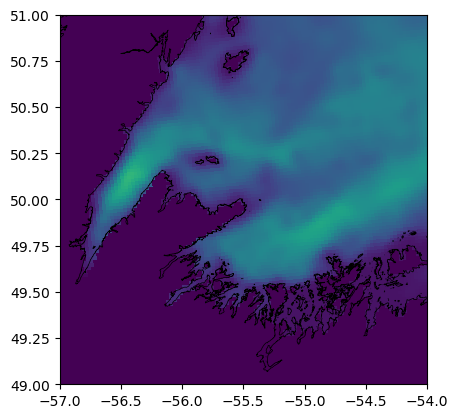

In [20]:
fig, ax = plt.subplots(1,1)
ax.pcolormesh(nav_lon, nav_lat, bathy_c.Bathymetry,vmin=gebco.depth.min(), vmax=gebco.depth.max())
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])

In [21]:
# interpolating ciopse to the same grid
long, latg = np.meshgrid(dcsub.lon.values, dcsub.lat.values)
ciopse_interp = griddata((nav_lon.values.flatten(), nav_lat.values.flatten()), 
                         bathy_c.Bathymetry.values.flatten(), 
                         (long, latg))

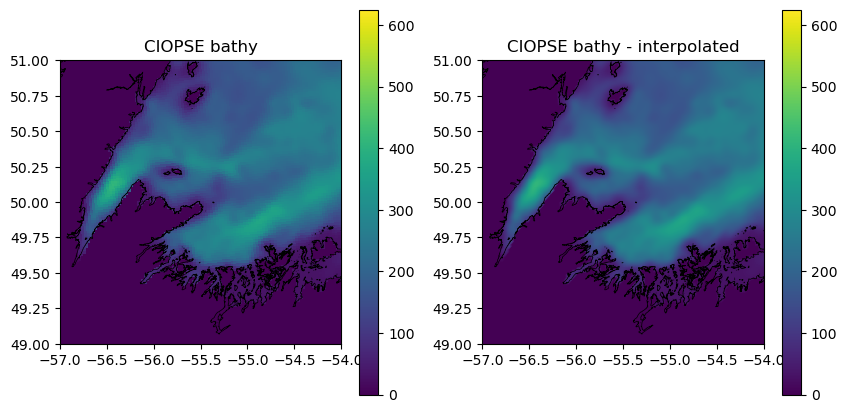

In [22]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
mesh = ax.pcolormesh(nav_lon, nav_lat, bathy_c.Bathymetry,vmin=gebco.depth.min(), vmax=gebco.depth.max())
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])
ax.set_title('CIOPSE bathy')
plt.colorbar(mesh)
ax=axs[1]
mesh = ax.pcolormesh(long, latg, ciopse_interp,vmin=gebco.depth.min(), vmax=gebco.depth.max())
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])
ax.set_title('CIOPSE bathy - interpolated')
plt.colorbar(mesh)

In [23]:
fig.savefig('ciopse_bathy_twill.png', bbox_inches='tight',dpi=200)

In [24]:
dcsub['ciopse_bathy_interp'] = xr.DataArray(ciopse_interp, dims=('lat', 'lon'))

In [25]:
dcsub_ciopse = dcsub.where(dcsub['ciopse_bathy_interp']>0)

In [26]:
diff = ciopse_interp- gebco_interp.depth 

In [27]:
reldiff = np.abs(diff)/(dcsub['ciopse_bathy_interp'])
thres=0.1

In [30]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
mesh = ax.pcolormesh(long, latg, diff, vmin=-100,vmax=100,cmap='RdBu_r')
plt.colorbar(mesh,ax=ax)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])
ax.set_title('ciopse - gebco')
ax=axs[1]
mesh = ax.pcolormesh(long, latg, reldiff,vmin=0,vmax=1)
plt.colorbar(mesh,ax=ax)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])
ax.set_title('abs(ciose-gebco)/(ciopse)')

Text(0.5, 1.0, 'abs(ciose-gebco)/(ciopse)')

In [31]:
fig.savefig('bathy_differences_twill.png', bbox_inches='tight',dpi=200)

In [32]:
mask = reldiff>thres

(-57.0, -54.0)

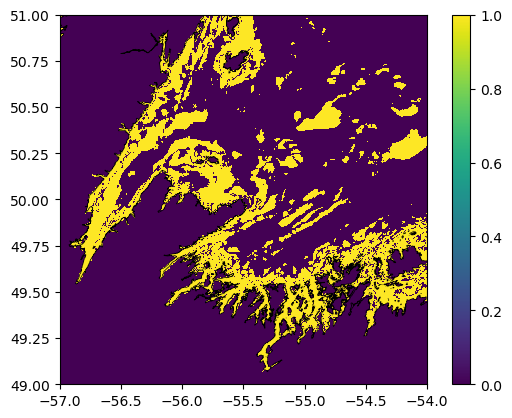

In [33]:
fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(long, latg, mask)
plt.colorbar(mesh,ax=ax)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])

In [34]:
dcsub['redzone_bathy'] = xr.DataArray(mask, dims=('lat', 'lon'))

(-57.0, -54.0)

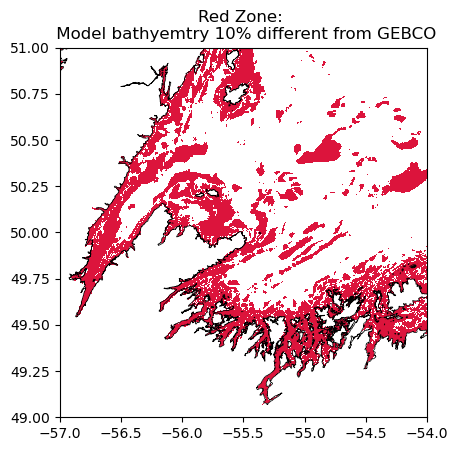

In [35]:
fig, ax = plt.subplots(1,1)
ax.pcolormesh(dcsub.lon, dcsub.lat, dcsub.redzone_bathy, cmap=cmap_red)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_title('Red Zone: \n Model bathyemtry 10% different from GEBCO')
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])

In [36]:
redzoneall = dcsub['redzone_bathy'] | dcsub['redzone_landmask']
dcsub['redzone_all'] = xr.DataArray(redzoneall, dims=('lat', 'lon'))

(-57.0, -54.0)

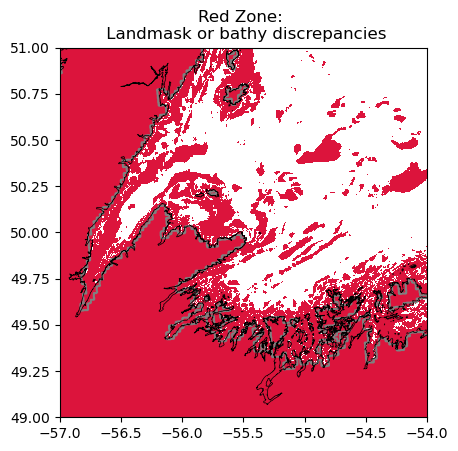

In [37]:

fig, ax = plt.subplots(1,1)
ax.pcolormesh(dcsub.lon, dcsub.lat, dcsub.redzone_all, cmap=cmap_red)
ax.contour(dciopse.lon, dciopse.lat, dciopse.mask, levels=[0], colors='grey')
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_title('Red Zone: \n Landmask or bathy discrepancies')
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])

In [38]:
fig.savefig('redzone_landmask_or_mistmatch_or_relbathydifference0.1_twill.png', bbox_inches='tight', dpi=300)